<a href="https://colab.research.google.com/github/jacomyma/dtu-sts-material/blob/main/notebooks/colab/Timeline_Filter_and_render.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeline - Filter and render

*DTU - Explore the Energy Islands controversy*

**Goal**:
- Filter the visualization using a condition (a **query**)
- Render the visualization as a static image
- Here we focus on the **proportion over time** of statements mentioning the Danish Energy Agency

**How to use (local/offline)**:
- Run this notebook with working directory = `assignment-D/`
- Run all cells
- Edit the query cell if you want to refine the vocabulary


## Settings

In [10]:
# SETTINGS (edit if necessary)
settings = {}
settings['year_first'] = 2019
settings['year_last'] = 2024
settings['plot_width']  = 12 # In cm
settings['plot_height'] =  6 # In cm

## Code

(You don't have to understand what's going on here, but feel free to take a look)

In [2]:
# Additional settings you shouldn't have to change
# (Local/offline version does not use Google Sheets)
settings['corpus_csv_path'] = 'Actor statement corpus - dataset.csv'

### Install stuff
Note: already installed libraries will not be reinstalled, don't worry about re-running that.

In [ ]:
# Optional installs (commented out for offline/local execution)
# !pip install pandas matplotlib

In [3]:
# Import necessary libraries (local/offline)
import pandas as pd
import json
import matplotlib.pyplot as plt

### Load data from the corpus

In [4]:
# Load the local CSV corpus
# (Make sure you run this notebook with working directory = the `assignment-D/` folder.)
df = pd.read_csv(settings['corpus_csv_path'])

In [5]:
# Basic cleanup / types
# Set 'Year' column to int
df['Year'] = df['Year'].replace('', pd.NA)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(pd.Int64Dtype())

# Set 'X', 'Y' and 'Size' columns to float
# (Not required for the timeline, but kept for consistency across notebooks)
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

print('Data loaded.')
print(f"Total statements in corpus: {len(df)}")

Data loaded.
Total statements in corpus: 6061


### Other prep we need

In [6]:
# This is the function we will use to visualize a matching condition
def visualize(condition, title='Proportion of filtered items'):
  # Make a copy of df
  df_copy = df.copy()

  # Mark each row of df_copy as filtered if the condition is fulfilled
  df_copy['filtered'] = condition

  # Plot a pie chart with counts and percentages
  filtered_counts = df_copy['filtered'].value_counts()

  def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          val = int(round(pct*total/100.0))
          return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
      return my_autopct

  # Define the colors for True and False
  colors = ['#4deded' if label else '#EAEAEA' for label in filtered_counts.index]

  # Create a figure with a small size
  plt.figure(figsize=(3, 3))

  plt.pie(filtered_counts, autopct=make_autopct(filtered_counts), colors=colors, startangle=90)
  plt.title(title)
  plt.show()

# Filtering condition (QUERY)

**Edit the condition (the query)**, then run this cell and those below to update them. Also give a title to your query for clarity.

Matches: 157 / 6061 (2.59%)


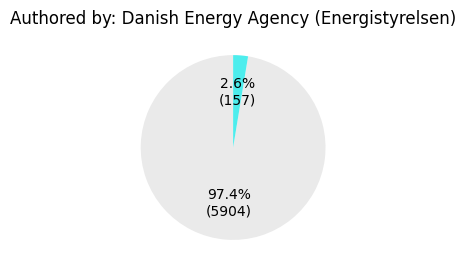

In [13]:
# EDIT ME
# Query: statements AUTHORED by the Danish Energy Agency
agency_actor_terms = (
    r"^The Danish Energy Agency$|"  # common English label
    r"^Danish Energy Agency$|"      # variant
    r"^Energistyrelsen$"            # Danish label (if present)
)

condition = df['Actor'].fillna('').str.contains(agency_actor_terms, case=False, na=False, regex=True)

# EDIT ME (give an appropriate title to the query)
title = "Authored by: Danish Energy Agency (Energistyrelsen)"

print(f"Matches: {int(condition.sum())} / {len(df)} ({condition.mean()*100:.2f}%)")

# Check that it works
visualize(condition, title)

# Render the visualizations

## 1. Timeline in absolute values, with context

PROs: Compares the query to the total. Comparable scales across different queries.

CONs: If the data volume is low, the pattern is too small to be visible, which also makes the small bars (low-volume months) impossible to analyze.

Figure saved as 'Timeline 1.png'.


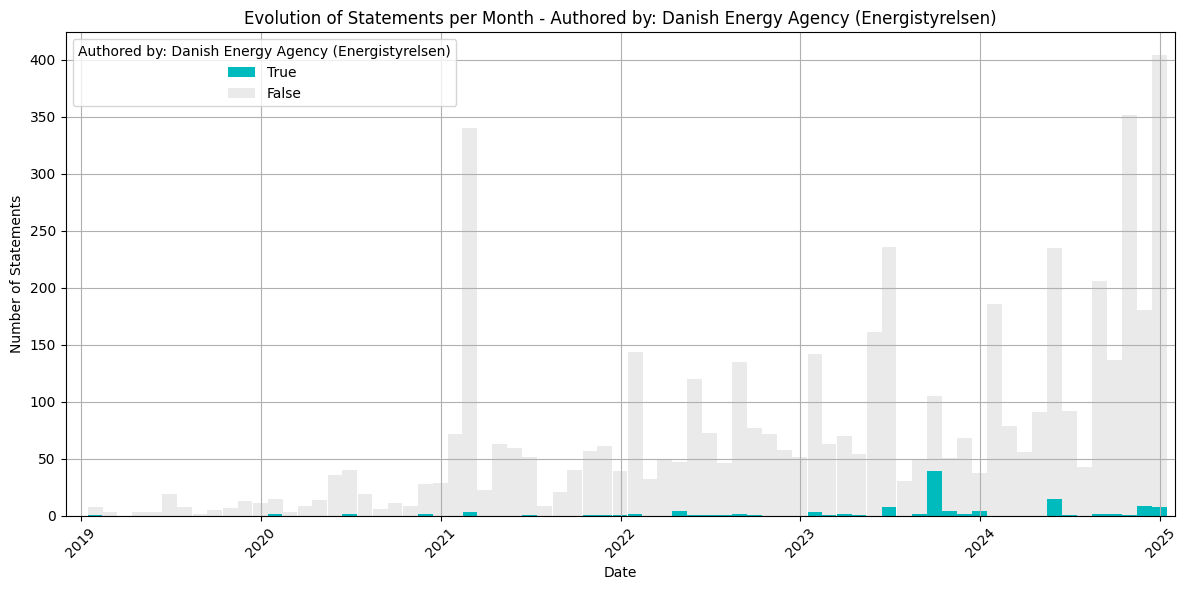

In [14]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Remove rows where Year is out of range
df_ = df_[df_['Year'] >= settings['year_first']]
df_ = df_[df_['Year'] <= settings['year_last']]

# Convert 'Date of publication' to datetime
df_['Date of publication'] = pd.to_datetime(df_['Date of publication'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates (NaT) resulting from the coercion
df_ = df_.dropna(subset=['Date of publication'])

# Group by month and filter status, then count statements
monthly_statements = df_.groupby([pd.Grouper(key='Date of publication', freq='ME'), 'filtered'])['filtered'].count().unstack(fill_value=0)

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Set the x-axis limits
plt.xlim(pd.to_datetime(f'{settings["year_first"]-1}-12-01'), pd.to_datetime(f'{settings["year_last"]+1}-01-31'))

try: plt.bar(monthly_statements.index, monthly_statements[True], width=30, color='#00bbbd', label='True')
except: pass

try: plt.bar(monthly_statements.index, monthly_statements[False], width=30, bottom=monthly_statements[True], color='#EAEAEA', label='False')
except: pass

plt.xlabel('Date')
plt.ylabel('Number of Statements')
plt.title('Evolution of Statements per Month - '+title)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title=title) # Display legend
plt.tight_layout()

# Save in 300dpi
filename = 'Timeline 1.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 2. Timeline in absolute values, no context

Same as above, except without the grey bars.

PROs: Readable even when the general volume is low.

CONs: We can't compare to the total. We can't compare multiple queries, as they will have different scalings. The low-volume categories remain impossible to analyze.

Figure saved as 'Timeline 2.png'.


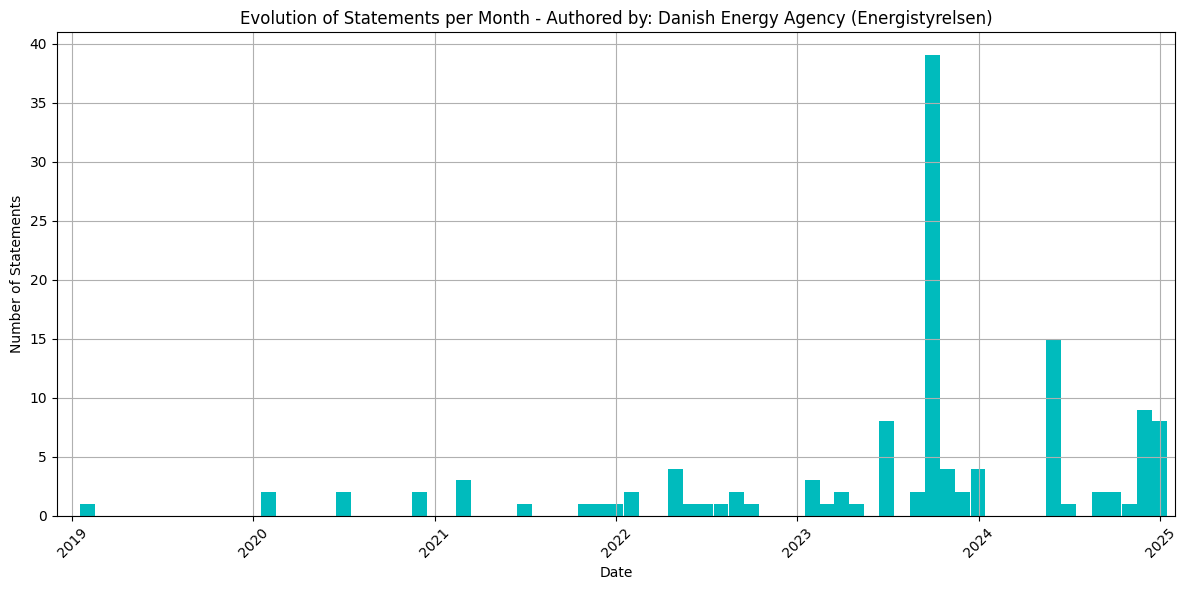

In [15]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Remove rows where Year is out of range
df_ = df_[df_['Year'] >= settings['year_first']]
df_ = df_[df_['Year'] <= settings['year_last']]

# Convert 'Date of publication' to datetime
df_['Date of publication'] = pd.to_datetime(df_['Date of publication'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates (NaT) resulting from the coercion
df_ = df_.dropna(subset=['Date of publication'])

# Group by month and filter status, then count statements
monthly_statements = df_.groupby([pd.Grouper(key='Date of publication', freq='ME'), 'filtered'])['filtered'].count().unstack(fill_value=0)

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Set the x-axis limits
plt.xlim(pd.to_datetime(f'{settings["year_first"]-1}-12-01'), pd.to_datetime(f'{settings["year_last"]+1}-01-31'))

try: plt.bar(monthly_statements.index, monthly_statements[True], width=30, color='#00bbbd', label='True')
except: pass

plt.xlabel('Date')
plt.ylabel('Number of Statements')
plt.title('Evolution of Statements per Month - '+title)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save in 300dpi
filename = 'Timeline 2.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 3. Timeline in percentages, with context

Instead of the absolute values, we plot the percentage of statements.

PROs: The percentage makes more sense in more situations, because it takes the context (total volume) into account. Compares the query to the total.

CONs: If the query is low-volume it may not be readable. Months with very low volume get overrepresented.

Figure saved as 'Timeline 3.png'.


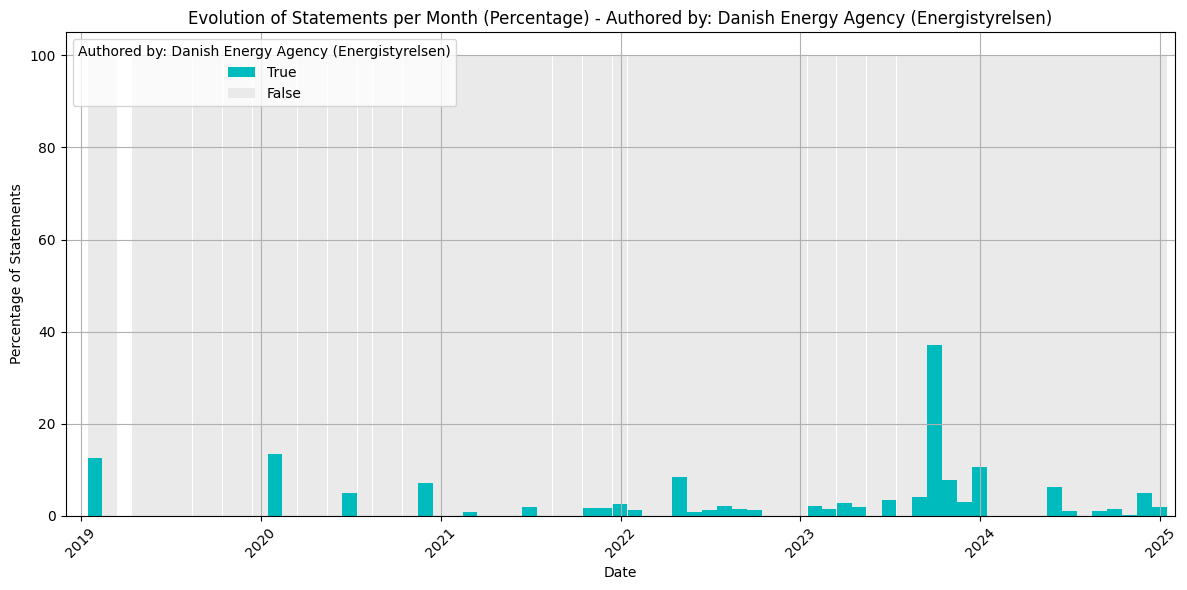

In [16]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Remove rows where Year is out of range
df_ = df_[df_['Year'] >= settings['year_first']]
df_ = df_[df_['Year'] <= settings['year_last']]

# Convert 'Date of publication' to datetime
df_['Date of publication'] = pd.to_datetime(df_['Date of publication'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates (NaT) resulting from the coercion
df_ = df_.dropna(subset=['Date of publication'])

# Group by month and filter status, then count statements
monthly_statements = df_.groupby([pd.Grouper(key='Date of publication', freq='ME'), 'filtered'])['filtered'].count().unstack(fill_value=0)

# Calculate percentages
monthly_statements_percentage = monthly_statements.div(monthly_statements.sum(axis=1), axis=0) * 100

# Create the bar chart
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Set the x-axis limits
plt.xlim(pd.to_datetime(f'{settings["year_first"]-1}-12-01'), pd.to_datetime(f'{settings["year_last"]+1}-01-31'))

try:
    plt.bar(monthly_statements_percentage.index, monthly_statements_percentage[True], width=30, color='#00BBBD', label='True')
    plt.bar(monthly_statements_percentage.index, monthly_statements_percentage[False], width=30, bottom=monthly_statements_percentage[True], color='#EAEAEA', label='False')
except:
    pass

plt.xlabel('Date')
plt.ylabel('Percentage of Statements')
plt.title('Evolution of Statements per Month (Percentage) - '+title)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title=title) # Display legend
plt.tight_layout()

# Save in 300dpi
filename = 'Timeline 3.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()

## 4. Timeline in percentages, no context

Same as above but we adapt the Y scale.

PROs: The percentage makes more sense in more situations. Always readable.

CONs: Categories with very low volume get overrepresented.

In [ ]:
# Duplicate df into df_
df_ = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_['filtered'] = condition

# Remove rows where Year is out of range
df_ = df_[df_['Year'] >= settings['year_first']]
df_ = df_[df_['Year'] <= settings['year_last']]

# Convert 'Date of publication' to datetime
df_['Date of publication'] = pd.to_datetime(df_['Date of publication'], format='%Y-%m-%d', errors='coerce')

# Drop rows with invalid dates (NaT) resulting from the coercion
df_ = df_.dropna(subset=['Date of publication'])

# Group by month and filter status, then count statements
monthly_statements = df_.groupby([pd.Grouper(key='Date of publication', freq='ME'), 'filtered'])['filtered'].count().unstack(fill_value=0)

# Calculate percentages (share of all statements in that month)
monthly_pct = monthly_statements.div(monthly_statements.sum(axis=1), axis=0) * 100
true_pct = monthly_pct.get(True)

# Create the plot (pattern-focused)
plt.figure(figsize=(settings['plot_width'], settings['plot_height']))

# Set the x-axis limits
plt.xlim(pd.to_datetime(f"{settings['year_first']-1}-12-01"), pd.to_datetime(f"{settings['year_last']+1}-01-31"))

if true_pct is not None and len(true_pct) > 0:
    plt.plot(true_pct.index, true_pct.values, color='#00BBBD', linewidth=2)
    plt.scatter(true_pct.index, true_pct.values, color='#00BBBD', s=25)

    # Find and annotate the peak
    peak_date = true_pct.idxmax()
    peak_val = float(true_pct.loc[peak_date])

    plt.scatter([peak_date], [peak_val], color='black', s=60, zorder=10)
    plt.annotate(
        f"Peak: {peak_date.strftime('%Y-%m')}\n{peak_val:.1f}%",
        xy=(peak_date, peak_val),
        xytext=(15, 25),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='black', lw=1),
        bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='none', alpha=0.85),
    )

    plt.ylim(0, max(5, peak_val * 1.25))

plt.xlabel('Date')
plt.ylabel('Share of statements authored by the agency (%)')
plt.title('Evolution of Danish Energy Agency authorship (monthly share) — ' + title)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save in 300dpi
filename = 'Timeline 4.png'
plt.savefig(filename, dpi=300)
print(f"Figure saved as '{filename}'.")

plt.show()